# SORT : Simple Online and Real-time Tracking
https://arxiv.org/abs/1602.00763
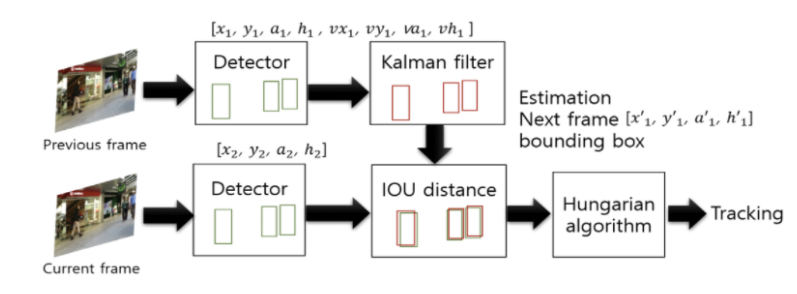

In [56]:
import os
import numpy as np

from filterpy.kalman import KalmanFilter

# Hungarian Algorithm

**문제정의**\
노동자와 작업을 1:1매칭하여 할당할 때 최소의 비용을 도출하는 방법\
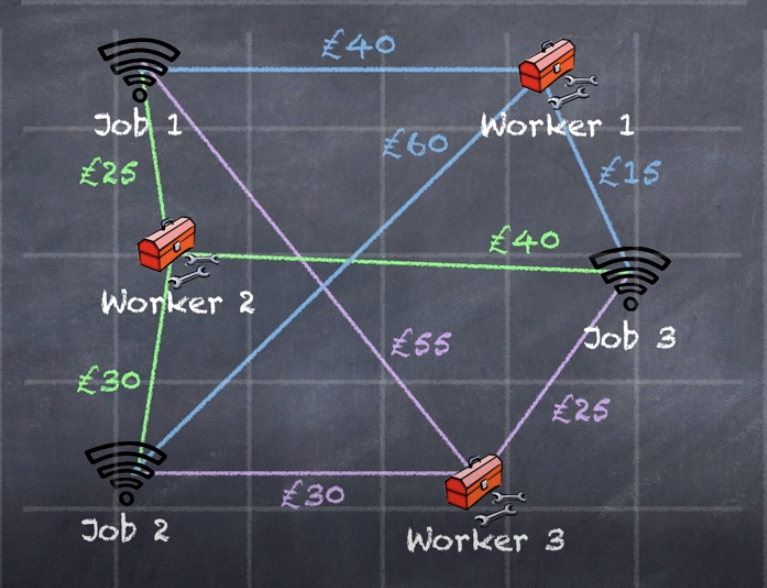



**예시**\
**1) 노동자를 행에 작업을 열에 대응하여 각각의 비용을 구한다.**

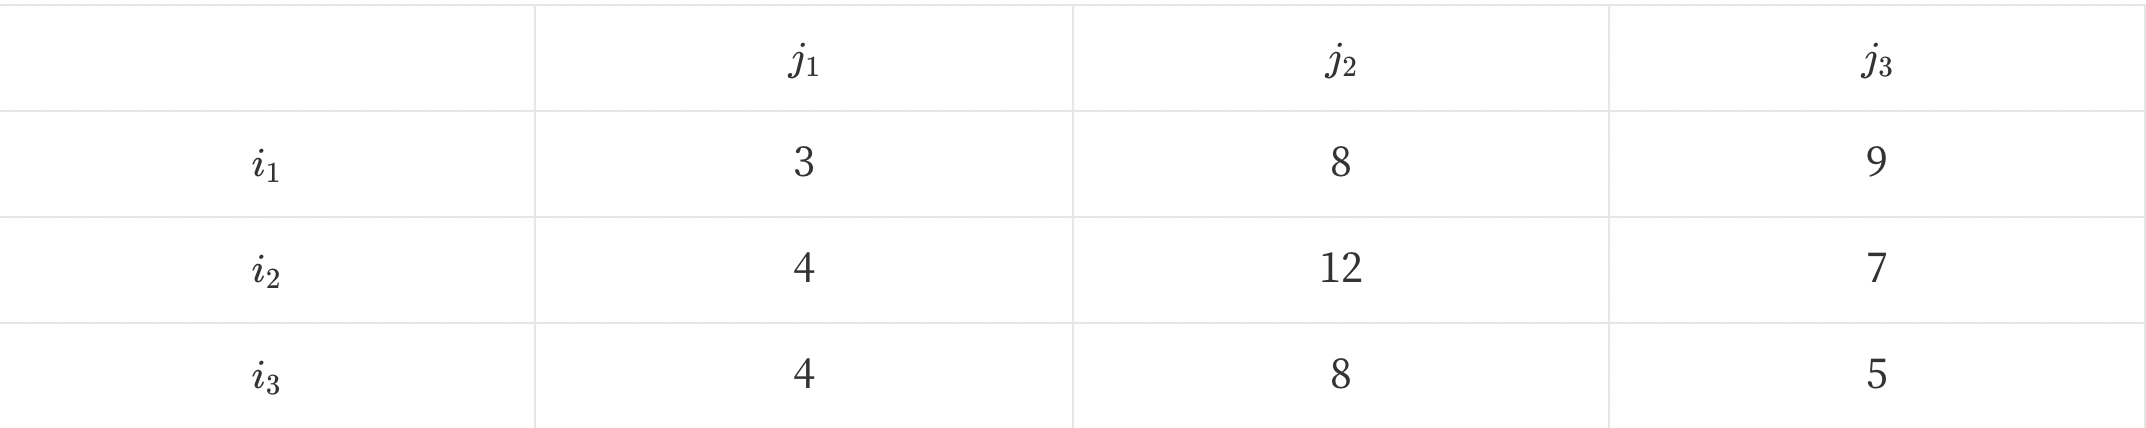



**2) 각 행/열의 최솟값을 빼준다.**\
**아직 0의 값을 가지는 노동자-작업이 1:1매칭이 안되므로 다음 단계로 넘어간다.**
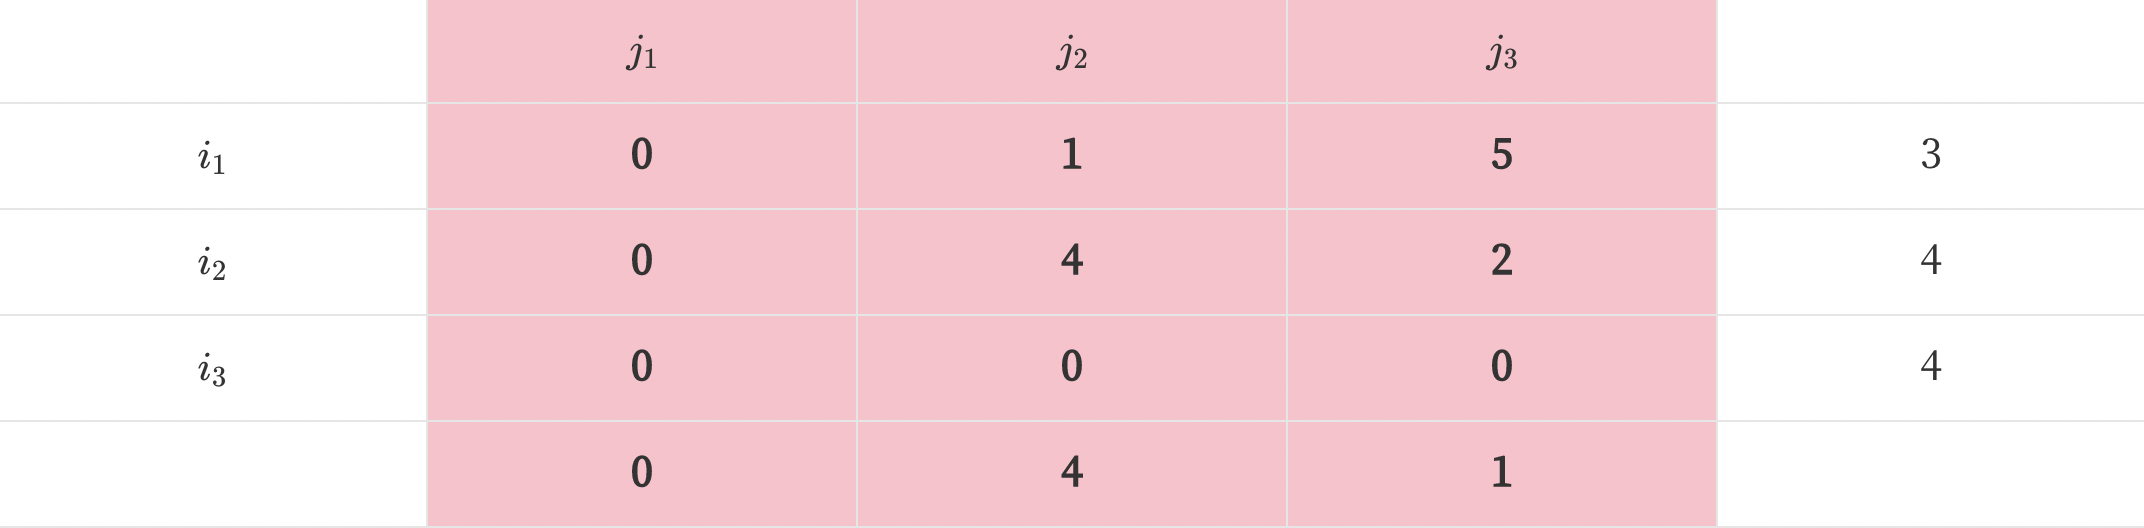


**3) 모든 값이 0인 3행을 제외한 1,2행에서 가장 작은 값인 1을 빼준다.**

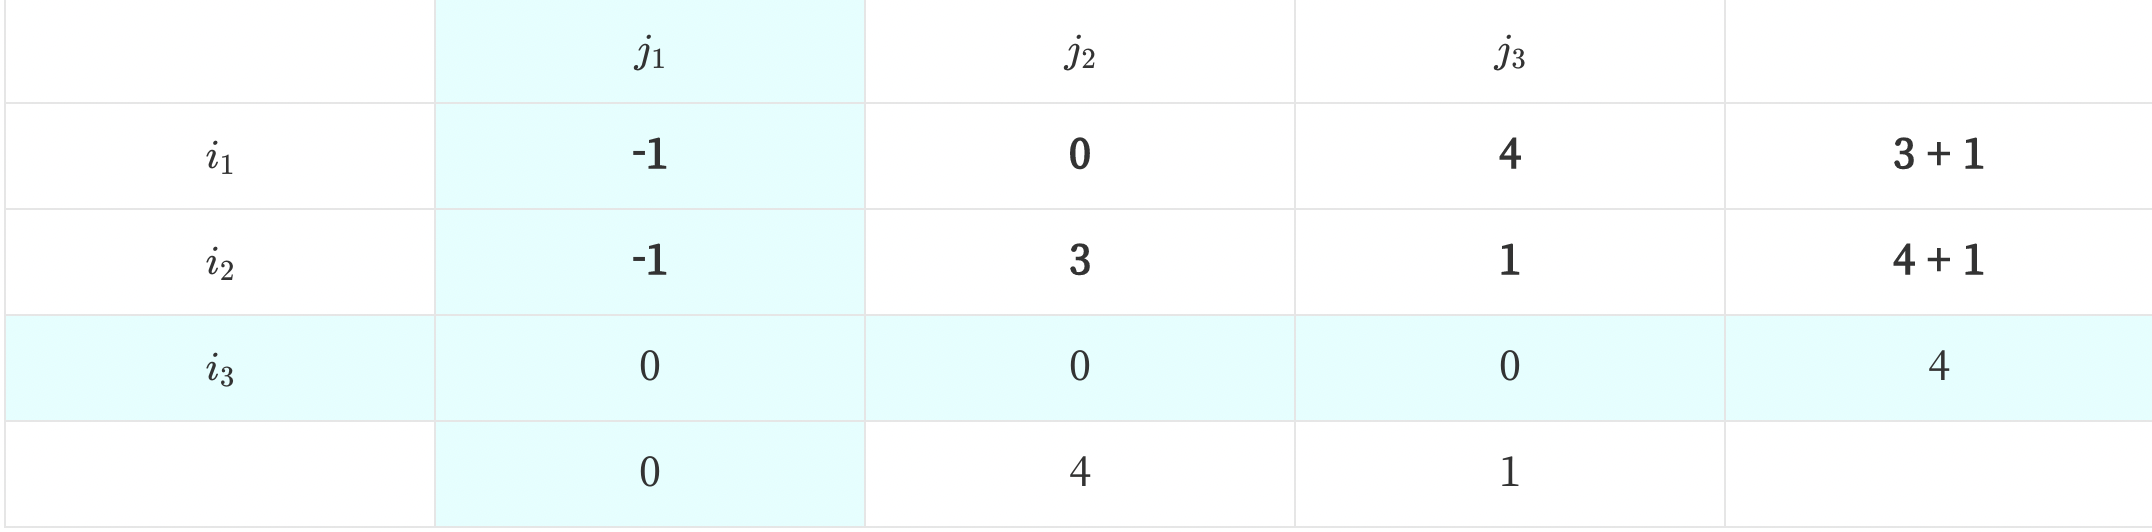



**4) 음수가 생겼으므로 1열에 1을 더해준다.**

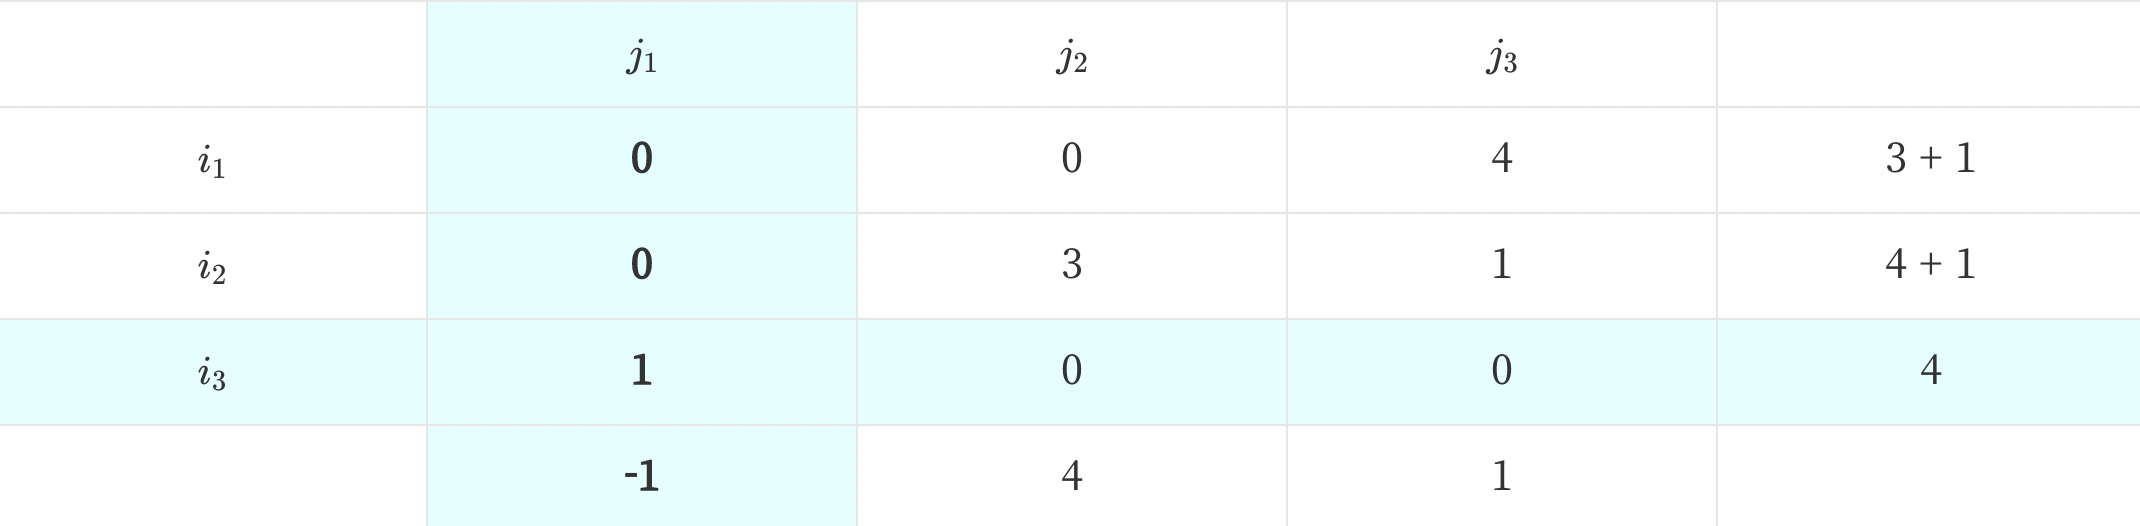



**5) 최적화된 조합이 선택된다.**

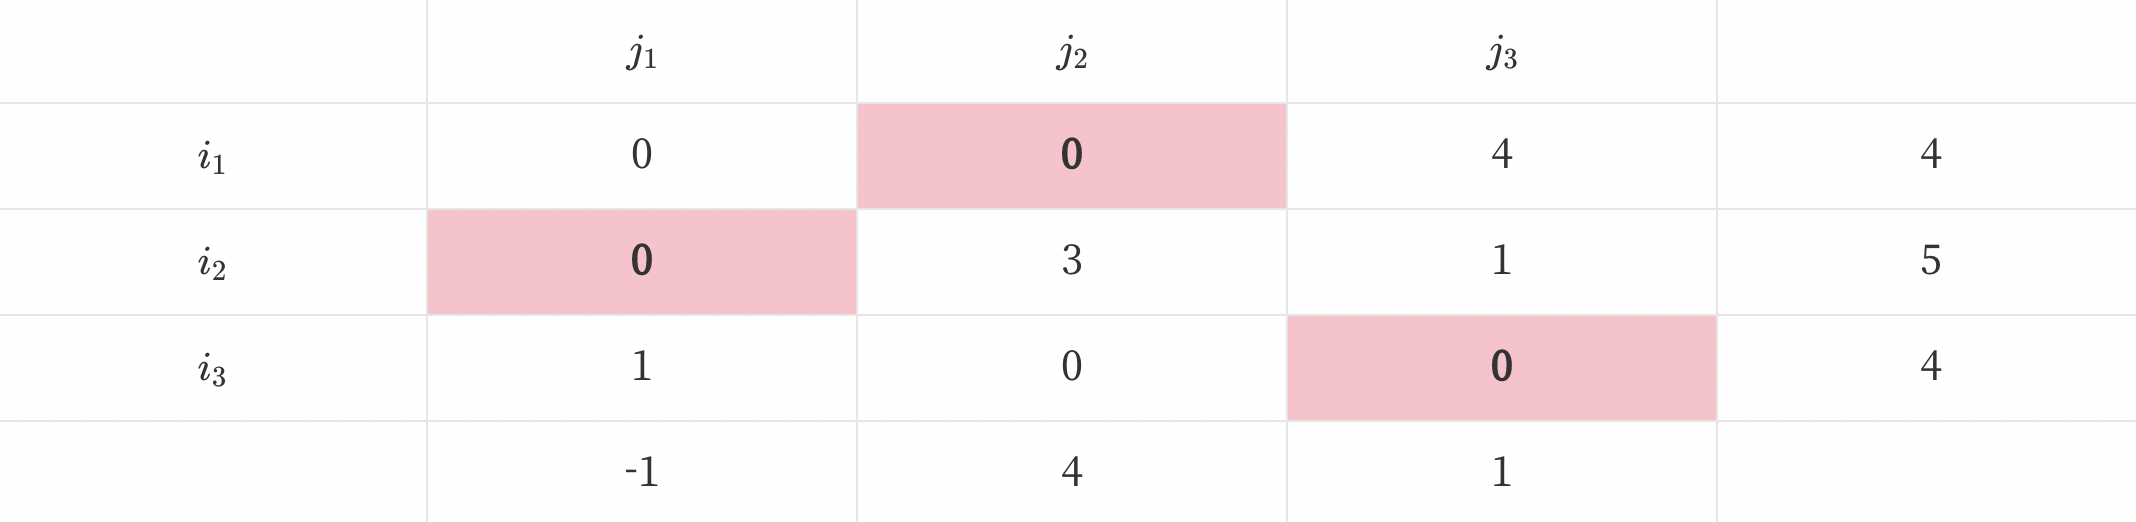

#### 출처
- https://gazelle-and-cs.tistory.com/29
- https://www.youtube.com/watch?v=cQ5MsiGaDY8&t=31s

# Utils

In [73]:
def linear_assignment(cost_matrix):
    try:
        import lap # Jonker-Volgenant algorithm (faster than hungarian algorithm)
        _, x, y = lap.lapjv(cost_matrix, extend_cost=True)
        return np.array([[y[i],i] for i in x if i >= 0]) 
    
    except ImportError: # Hungarian algorithm
        from scipy.optimize import linear_sum_assignment
        x, y = linear_sum_assignment(cost_matrix)
        return np.array(list(zip(x, y)))
    
def iou_batch(bb_test, bb_gt): # bb_test(pred_bb_num, 4)  bb_gt(real_bb_num, 4)  
    """
    From SORT: Computes IOU between two bboxes in the form [x1,y1,x2,y2]
    """
    bb_gt = np.expand_dims(bb_gt, 0) # (1, real_bb_num, 4)
    bb_test = np.expand_dims(bb_test, 1) # (pred_bb_num, 1, 4)
  
    # 교차하는 box의 좌표
    xx1 = np.maximum(bb_test[..., 0], bb_gt[..., 0])
    yy1 = np.maximum(bb_test[..., 1], bb_gt[..., 1])
    xx2 = np.minimum(bb_test[..., 2], bb_gt[..., 2])
    yy2 = np.minimum(bb_test[..., 3], bb_gt[..., 3])
    w = np.maximum(0., xx2 - xx1)
    h = np.maximum(0., yy2 - yy1)
    wh = w * h
    
    # IOU 구하기. bb_test가 행, bb_gt가 열인 matrix
    o = wh / ((bb_test[..., 2] - bb_test[..., 0]) * (bb_test[..., 3] - bb_test[..., 1])                                      
        + (bb_gt[..., 2] - bb_gt[..., 0]) * (bb_gt[..., 3] - bb_gt[..., 1]) - wh)                                              
    return(o)  

    """
    bb_test = np.array([[1,2,5,6],
                        [2,4,6,9],
                        [5,4,6,10]])

    bb_gt = np.array([[1,3,4,5],
                      [6,3,9,4]])

    bb_gt = np.expand_dims(bb_gt, 0)
    bb_test = np.expand_dims(bb_test, 1)

    xx1 = np.maximum(bb_test[..., 0], bb_gt[..., 0])

    xx1
    >>array([[1, 6],
             [2, 6],
             [5, 6]])
    """

def convert_bbox_to_z(bbox):

    # (x1, y1, x2, y2) -> (cx, cy, scale, aspect ratio)
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    x = bbox[0] + w/2.
    y = bbox[1] + h/2.
    s = w * h    #scale is just area
    r = w / float(h)
    return np.array([x, y, s, r]).reshape((4, 1)) # shape은 (4,1)


def convert_x_to_bbox(x,score=None):

    # (cx, cy, scale, aspect ratio) -> (x1, y1, x2, y2, score) score는 있을때만
    w = np.sqrt(x[2] * x[3])
    h = x[2] / w
    if(score==None):
        return np.array([x[0]-w/2.,x[1]-h/2.,x[0]+w/2.,x[1]+h/2.]).reshape((1,4))
    else:
        return np.array([x[0]-w/2.,x[1]-h/2.,x[0]+w/2.,x[1]+h/2.,score]).reshape((1,5))


# Kalman Filter
Update(x', P') - Predict(x, P) - Update(x', P') - Predict(x, P) .... (Iteration)

**Notation**\
**F** : State가 어떻게 변하는지에 대한 Transition Matrix (n x n)\
**H** : State에 대해서 추정값이 뭔지를 알려주는 Measure Matrix (m x m)\
**R** : 측정잡음 (n x 1), **Q** : 시스템 잡음 (m x 1), 잡음은 평균=0인 정규분포\
**P** : 오차공분산 (참값과 추정값 사이의 오차를 나타내는 척도)

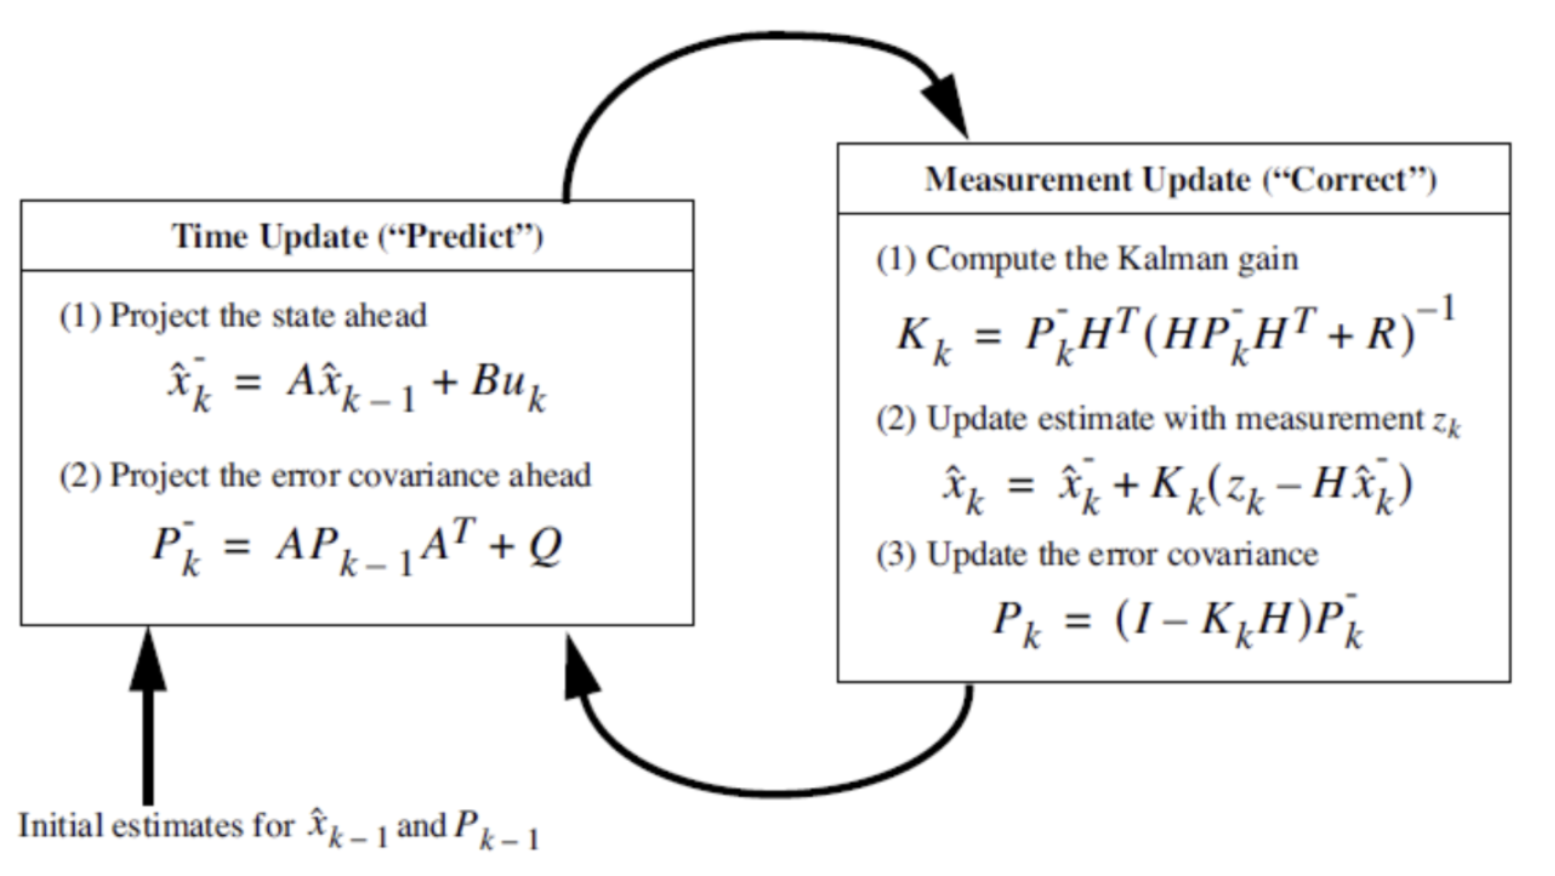

-은 예측값을 의미한다

예측값-를 '로 표기

1. 초깃값 설정 (x, P)\
<여기부터 Iteration. Update와 Predict>
2. 추정값과 오차 공분산 예측. (x^', P')
3. 칼만 이득 계산. K = P'H/(HP'H + R)\
계속 변화하는 가중치
4. 추정값 계산. (predict) x^ = x^' + K(z - Hx^')\
z : detection(측정값)\
측정값의 예측오차로 예측값을 적절히 보정해 최종 추정값 수정
5. 오차 공분산 계산. P = P' - KHP'\
   x~N(x^,P)

R이 크면 칼만이득은 감소. 측정값 반영비율이 작아지고 예측값 반영비율이 커진다.\
Q가 크면 칼만이득은 증가. 측정값 반영비율이 증가하고 예측값 반영비율이 작아진다.

#### 출처
- 『칼만 필터는 어렵지 않아』, 김성필 저.
- https://sharehobby.tistory.com/entry/%EC%B9%BC%EB%A7%8C-%ED%95%84%ED%84%B0Kalman-filter1

In [67]:
class KalmanBoxTracker(object):
    """
    This class represents the internal state of individual tracked objects observed as bbox.
    """
    count = 0
    def __init__(self,bbox):
        """
        x,y,s,r,x',y',s' (state)
        x -> x'
        y -> y'
        s -> s'
        r -> r (constant)
        """

        """
        KalmanFilter instance variables
        x : ndarray (dim_x, 1), default = [0,0,0…0]
            filter state estimate
        P : ndarray (dim_x, dim_x), default eye(dim_x)
            covariance matrix
        Q : ndarray (dim_x, dim_x), default eye(dim_x)
            Process uncertainty/noise
        R : ndarray (dim_z, dim_z), default eye(dim_x)
            measurement uncertainty/noise
        H : ndarray (dim_z, dim_x)
            measurement function
        F : ndarray (dim_x, dim_x)
            state transistion matrix
        B : ndarray (dim_x, dim_u), default 0
            control transition matrix
        """
        
        #define constant velocity model
        self.kf = KalmanFilter(dim_x=7, dim_z=4) # x(state)의 형태, z(output)의 형태
        
        # State transistion matrix
        self.kf.F = np.array([[1,0,0,0,1,0,0],[0,1,0,0,0,1,0],[0,0,1,0,0,0,1],[0,0,0,1,0,0,0], [0,0,0,0,1,0,0],[0,0,0,0,0,1,0],[0,0,0,0,0,0,1]])
        
        # Measure function
        self.kf.H = np.array([[1,0,0,0,0,0,0],[0,1,0,0,0,0,0],[0,0,1,0,0,0,0],[0,0,0,1,0,0,0]])

        # 측정 잡음(noise)
        self.kf.R[2:,2:] *= 10.
        
        # 공분산 행렬
        self.kf.P[4:,4:] *= 1000. # x', y', s' 미래에 대한 내용. uncertainty를 높게 부여해주자. (공분산 값 높이기)
        self.kf.P *= 10.
        
        # 시스템 잡음(noise)
        self.kf.Q[-1,-1] *= 0.01 
        self.kf.Q[4:,4:] *= 0.01

        self.kf.x[:4] = convert_bbox_to_z(bbox) #(cx, cy, scale, aspect ratio)
        
        self.time_since_update = 0
        self.id = KalmanBoxTracker.count
        KalmanBoxTracker.count += 1
        self.history = []
        self.hits = 0
        self.hit_streak = 0
        self.age = 0

    def update(self,bbox): # 그림의 우측박스
        """
        Add a new measurement (z) to the Kalman filter, z: (dim_z,1)
    
        """
        self.time_since_update = 0
        self.history = []
        self.hits += 1
        self.hit_streak += 1
        self.kf.update(convert_bbox_to_z(bbox)) #(cx, cy, scale, aspect ratio)

    def predict(self): # 그림의 좌측 박스
        """
        Advances the state vector and returns the predicted bounding box estimate.
        """
        if((self.kf.x[6]+self.kf.x[2])<=0): # 현재와 그 다음 scale의 합이 음수인 경우 0으로
            self.kf.x[6] *= 0.0
    
        # x = Fx + Bu, P = FPF + Q 
        self.kf.predict()
    
        self.age += 1
        if(self.time_since_update>0): # 바로 다음에 update되지 않은 경우
            self.hit_streak = 0       # hit_streak(연속 hit 기록)을 0으로
    
        self.time_since_update += 1
        self.history.append(convert_x_to_bbox(self.kf.x)) #(x1,y1,x2,y2,score)
        return self.history[-1] 

    def get_state(self):
        """
        현재 bbox estimate 리턴
        """
        return convert_x_to_bbox(self.kf.x)

    def associate_detections_to_trackers(detections,trackers,iou_threshold = 0.3):
        
        """
        detections: pred
        trackers: gt
        """
        
        # gt가 없는 경우
        if(len(trackers)==0):
            # matches에는 빈 리스트(pred와 gt가 들어가므로 0,2), detections의 index, ???
            return np.empty((0,2),dtype=int), np.arange(len(detections)), np.empty((0,5),dtype=int)

        iou_matrix = iou_batch(detections, trackers) 
        
        #pred와 gt의 개수가 둘 다 0이 아닌 경우
        if min(iou_matrix.shape) > 0:
            a = (iou_matrix > iou_threshold).astype(np.int32) #임계값 넘으면 1
            
            # matrix의 행의 합과 열의 합의 최댓값이 1이면 즉, 하나의 gt에 대해 만족하는 pred_box가 1개 이하라면
            if a.sum(1).max() == 1 and a.sum(0).max() == 1: 
                matched_indices = np.stack(np.where(a), axis=1)
                """
                a=np.array([[1,0,0,0], 
                            [0,1,0,0],
                            [0,0,0,1]])
                np.where(a) = [0,1,2], [0,1,3] 열과 행에 대해 0이 아닌 곳의 위치
                np.stack(np.where(a), axis=1) = [[0,0],
                                                 [1,1],   
                                                 [2,3]]
                """
            # 헝가리안 알고리즘은 비용을 최소로 만드므로 iou에 -를 붙여 iou가 최대가 되는 값의 조합이 나오도록
            else: 
                matched_indices = linear_assignment(-iou_matrix)
        else:
            matched_indices = np.empty(shape=(0,2))
        
        # 매칭되지 못한 pred_box, gt_box 리스트
        unmatched_detections = []
        for d, det in enumerate(detections):
            if(d not in matched_indices[:,0]):
                unmatched_detections.append(d)
        unmatched_trackers = []
        for t, trk in enumerate(trackers):
            if(t not in matched_indices[:,1]):
                unmatched_trackers.append(t)

        # 매칭된 조합 중 IOU가 낮은 것들 필터링
        matches = []
        for m in matched_indices:
            if(iou_matrix[m[0], m[1]]<iou_threshold):
                unmatched_detections.append(m[0])
                unmatched_trackers.append(m[1])
            else:
                matches.append(m.reshape(1,2))
        if(len(matches)==0):
            matches = np.empty((0,2),dtype=int)
        else:
            matches = np.concatenate(matches,axis=0)

        return matches, np.array(unmatched_detections), np.array(unmatched_trackers)

# Model

In [72]:
class Sort(object):
    def __init__(self, max_age=1, min_hits=3, iou_threshold=0.3):
        
        
        self.max_age = max_age    # 최대 age (최대 age보다 더 긴 시간동안 update되지 않으면 제거)
        self.min_hits = min_hits  # 판정 기준 - 어느 정도 프레임을 유지해야 포함시킬 수 있음
        self.iou_threshold = iou_threshold 
        self.trackers = []     # KalmanBoxTracker 객체로 이루어진 리스트. 
        self.frame_count = 0   
        
    def update(self, dets=np.empty((0, 5))):
        '''
        Params:
            dets - detections [[x1, y1, x2, y2, score], [x1, y1, x2, y2, score], ..]
        
        Require: this method must be called once for each frame even with empty detections
        Returns a similar array, where the last column is the object ID
        '''
        self.frame_count += 1
        
        trks = np.zeros((len(self.trackers), 5))  # object 개수, (x1,y1,x2,y2,score)
        to_del = []
        ret = []
        
        for t, trk in enumerate(trks):
            pos = self.trackers[t].predict()[0]
            trk[:] = [pos[0], pos[1], pos[2], pos[3], 0]  
            # pos는 예측된 값으로, score는 0으로 초기화
                
            if np.any(np.isna(pos)):  # na값이 하나라도 존재하면 to_del에 append
                to_del.append(t)
                
        trks = np.ma.compress_rows(np.ma.masked_invalid(trks))
            # np.ma.masked_invalid : Na값이나 inf값에 대하여 True, 나머지는 False를 반환
            # compress_rows : 모든 값이 mask=False인 row만!
            # 즉, 모든 값이 Na값이나 inf값이 아닌 row만 trks로 설정
        
        # to_del에 있는 항목들 pop 해주기
        for t in reversed(to_del):
            self.trackes.pop(t)
            
        # dets와 trks associate 해주기
        matched, unmatched_dets, unmatched_trks = \
            associate_detections_to_trackers(dets, trks, self.iou_threshold)
            
        
        # Update matched trackers with assigned detections
        for m in matched: 
            self.trackers[m[1]].update(dets[m[0], :]) # m[0]은 pred m[1]은 gt
        
        # Create and initialize new trackers for unmatched detections
        for i in unmatched_dets:
            trk = KalmanBoxTracker(dets[i, :])
            self.trackers.append(trk)
        i = len(self.trackers)
        
        for trk in reversed(self.trackers):
            d = trk.get_state()[0]
            # 이전 시점에서도 update 되었고 연속 hit가 min_hit 이상
            # 혹은 frame_count가 min_hits보다 작으면
            if (trk.time_since_update < 1) and (trk.hit_streak >= self.min_hits or self.frame_count <= self.min_hits):   
                ret.append(np.concatenate((d, [trk.id+1])).reshape(1, -1))  
            i -= 1
            
            # remove dead tracklet
            # max_age (최대 나이)보다 time_since_update가 길면 제거
            if (trk.time_since_update > self.max_age):  
                self.trackers.pop(i)                  
                
        if len(ret) > 0:
            return np.concatenate(ret)
        return np.empty((0, 5))

# Train

In [ ]:
def parse_args():
    '''
    Parse input arguments
    Usage:
        ex) python train.py train --epochs 100 --batch-size 10 
    '''
    parser = argparse.ArgumentParser(description='SORT demo')
    parser.add_argument('--display', dest='display', help='Display online tracker output (slow) [False]',action='store_true')
    parser.add_argument("--seq_path", help="Path to detections.", type=str, default='data')
    parser.add_argument("--phase", help="Subdirectory in seq_path.", type=str, default='train')
    parser.add_argument("--max_age", 
                        help="Maximum number of frames to keep alive a track without associated detections.", 
                        type=int, default=1)
    parser.add_argument("--min_hits", 
                        help="Minimum number of associated detections before track is initialised.", 
                        type=int, default=3)
    parser.add_argument("--iou_threshold", help="Minimum IOU for match.", type=float, default=0.3)
    args = parser.parse_args()
    return args

if __name__ == '__main__':
    
    # all train
    args = parse_ages()
    display = args.display
    phase = args.phase
    total_time = 0.0
    total_frame = 0
    colours = np.random.rand(32, 3)  # used only for display
    
    if display:
        if not os.path.exists('mot_benchmark'):
            print('\n\tERROR: mot_benchmark link not found!\n\n    Create a symbolic link to the MOT benchmark\n    (https://motchallenge.net/data/2D_MOT_2015/#download). E.g.:\n\n    $ ln -s /path/to/MOT2015_challenge/2DMOT2015 mot_benchmark\n\n')
            exit()
        plt.ion()
        fig = plt.figure()
        ax1 = fig.add_subplot(111, aspect='equal')
        
    if not os.path.exists('output'):
        os.makedir('output')
    
    pattern = os.path.join(args.seq_path, phase, '*', 'det', 'det.txt')
    for seq_dets_fn in glob.glob(pattern):
        # create instance of the Sort tracker
        mot_tracker = Sort(max_age=args.max_age,
                          min_hits=args.min_hits,
                          iou_threshold=args.iou_threshold)  
        seq_dets = np.loadtxt(seq_dets_fn, delimiter=',')
        seq = seq_dets_fn[pattern.find('*'):].split(os.path.seq)[0]
        
        with open(os.path.join('output', '%s.txt'%(seq)), 'w') as out_file:
            print('Processing %s.'%(seq))
            for frame in range(int(seq_dets[:, 0].max())):
                frame += 1  # detection and frame numbers begin at 1
                dets = seq_dets[seq_dets[:, 0] == frame, 2:7]
                dets[:, 2:4] += dets[:, 0:2]  # [x1, y1, w, h] -> [x1, y1, x2, y2]
                total_frames += 1
                
                if display:
                    fn = os.path.join('mot_benchmark', phase, seq, 'img1', '%06d.jpg'%(frame))
                    im = io.imread(fn)
                    ax1.imshow(im)
                    plt.title(seq + ' Tracked Targets')
                
                start_time = time.time()
                trackers = mot_tracker.update(dets)
                cycle_time = time.time() - start_time
                total_time += cycle_time
                
                for d in trackers:
                    print('%d,%d,%.2f,%.2f,%.2f,%.2f,1,-1,-1,-1'%(frame,d[4],d[0],d[1],d[2]-d[0],d[3]-d[1]),file=out_file)
                    if(display):
                        d = d.astype(np.int32)
                        ax1.add_patch(patches.Rectangle((d[0],d[1]),d[2]-d[0],d[3]-d[1],fill=False,lw=3,ec=colours[d[4]%32,:]))
                
                if display:
                    fig.canvas.flush_events()
                    plt.draw()
                    ax1.cla()
        
        print("Total Tracking took: %.3f seconds for %d frames or %.1f FPS" % (total_time, total_frames, total_frames / total_time))

        if(display):
            print("Note: to get real runtime results run without the option: --display")
